<a href="https://www.kaggle.com/code/sbhatti34/the-silent-epidemic-during-covid?scriptVersionId=247766144" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib
import seaborn as sns
plt.style.use('seaborn-v0_8-muted')
from IPython.display import display
from scipy import stats


%pip install missingno
from IPython.display import clear_output
import missingno as msno

from scipy.stats import ttest_ind

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report


from IPython.display import display
import matplotlib.ticker as ticker

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

clear_output()

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    

/kaggle/input/mental-health-in-the-last-4-weeks-covid/Mental_Health_Care_in_the_Last_4_Weeks.csv
/kaggle/input/mental-health-care-in-the-last-4-weeks/Mental Health Care in the Last 4 Weeks.csv


In [3]:
df=pd.read_csv("/kaggle/input/mental-health-in-the-last-4-weeks-covid/Mental_Health_Care_in_the_Last_4_Weeks.csv")

# &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;# Basic understanding of the dataset

In [4]:
df.shape

(10404, 15)

In [5]:
df.info()
print()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10404 entries, 0 to 10403
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Indicator               10404 non-null  object 
 1   Group                   10404 non-null  object 
 2   State                   10404 non-null  object 
 3   Subgroup                10404 non-null  object 
 4   Phase                   10404 non-null  object 
 5   Time Period             10404 non-null  int64  
 6   Time Period Label       10404 non-null  object 
 7   Time Period Start Date  10404 non-null  object 
 8   Time Period End Date    10404 non-null  object 
 9   Value                   9914 non-null   float64
 10  LowCI                   9914 non-null   float64
 11  HighCI                  9914 non-null   float64
 12  Confidence Interval     9914 non-null   object 
 13  Quartile Range          6732 non-null   object 
 14  Suppression Flag        22 non-null   

,Time Period,Value,LowCI,HighCI,Suppression Flag
count,10404.000000,9914.000000,9914.000000,9914.000000,22.0
mean,28.134948,17.450736,14.771565,20.475661,1.0
std,11.040210,8.270565,7.659396,9.052521,0.0
min,1.000000,1.400000,0.800000,2.000000,1.0
25%,20.000000,10.300000,8.000000,12.900000,1.0
50%,29.000000,16.200000,13.900000,19.200000,1.0
75%,37.000000,24.000000,20.800000,27.400000,1.0
max,45.000000,62.900000,53.200000,71.900000,1.0


In [6]:
df.columns = df.columns.str.strip()


In [7]:
# Rename the columns for better readability
indicator_rename_map = {
    'Took Prescription Medication for Mental Health, Last 4 Weeks': 'Took Medication',
    'Received Counseling or Therapy, Last 4 Weeks': 'Received Counseling or Therapy',
    'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks': 'Took medication AND/OR therapy',
    'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks': "Needed therapy but didn't get it"
}

df['Indicator'] = df['Indicator'].replace(indicator_rename_map)


Text(0.5, 0, '')

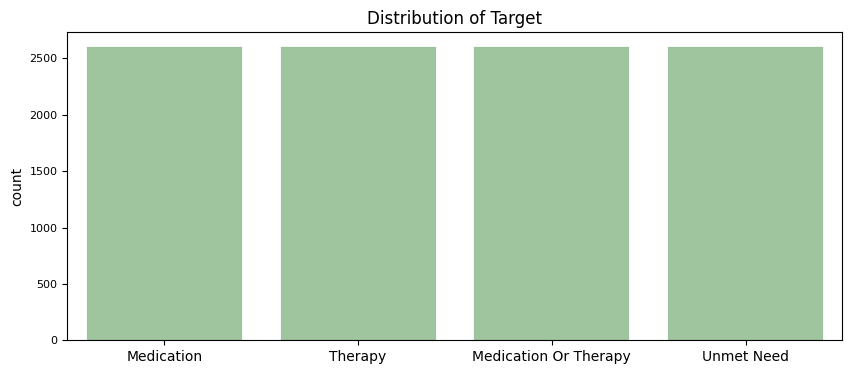

In [8]:

# Visualize the distribution of the target variable to ensure we have enough of each category
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='Indicator', color='green', linewidth=0.2, edgecolor='gray', alpha=0.4)
plt.xticks(ticks=np.arange(4), labels=['Medication', 'Therapy', 'Medication Or Therapy', 'Unmet Need'], fontsize=10)  # Adjust font size for x-axis ticks
plt.yticks(fontsize=8)  # Adjust font size for y-axis ticks
plt.title('Distribution of Target')
plt.xlabel("")

# Visualizing missing data, dropping rows with smallest % of missing data

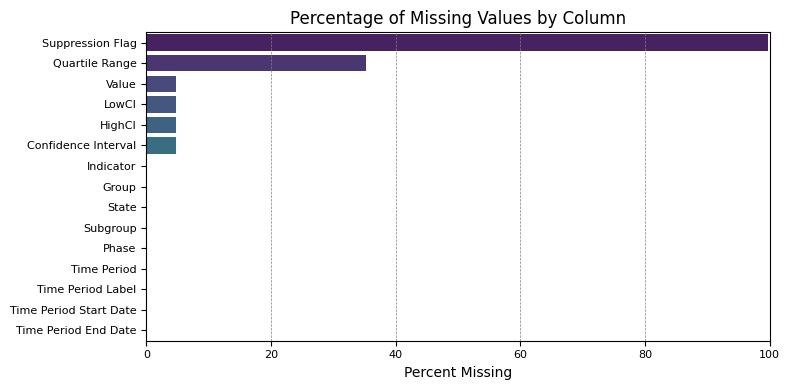

=== Missing Data Stats ===
Suppression Flag          99.788543
Quartile Range            35.294118
Value                      4.709727
LowCI                      4.709727
HighCI                     4.709727
Confidence Interval        4.709727
Indicator                  0.000000
Group                      0.000000
State                      0.000000
Subgroup                   0.000000
Phase                      0.000000
Time Period                0.000000
Time Period Label          0.000000
Time Period Start Date     0.000000
Time Period End Date       0.000000
dtype: float64

=== Row Count Analysis ===
Initial Rows: 10404
Rows After Removal: 9914
Rows Removed: 490
Percent Removed: 4.71%


In [9]:


# Step 1: Visualize missing data
plt.figure(figsize=(8, 4))
missing_data = df.isnull().mean().sort_values(ascending=False) * 100
sns.barplot(x=missing_data.values, y=missing_data.index, palette='viridis')
plt.xticks(fontsize=8)  # Adjust font size for x-axis ticks
plt.yticks(fontsize=8)  # Adjust font size for y-axis ticks
plt.xlim(0, 100)  # Set x-axis limit to 100%
plt.axvline(x=20, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=40, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=60, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(x=80, color='gray', linestyle='--', linewidth=0.5)
plt.title('Percentage of Missing Values by Column')
plt.xlabel('Percent Missing')
plt.ylabel('')
plt.tight_layout()

clear_output()
plt.show()

# Step 2: Count rows before and after dropping rows with missing core values
initial_row_count = len(df)
filtered_df = df.dropna(subset=['Value', 'LowCI', 'HighCI'])
filtered_row_count = len(filtered_df)
rows_removed = initial_row_count - filtered_row_count

# Step 3: Calculate percentage of data removed
percent_removed = (rows_removed / initial_row_count) * 100

# Display results
print("=== Missing Data Stats ===")
print(missing_data)

print("\n=== Row Count Analysis ===")
print(f"Initial Rows: {initial_row_count}")
print(f"Rows After Removal: {filtered_row_count}")
print(f"Rows Removed: {rows_removed}")
print(f"Percent Removed: {percent_removed:.2f}%")



## 📊 Missing Data Summary

A comprehensive view of missing data proportions across key variables helps guide responsible data handling and interpretation:


## 📉 Row Count Analysis

Understanding the impact of data cleaning on the overall dataset:

- **Initial Rows**: 10,404  
- **Rows After Cleaning**: 9,914  
- **Rows Removed**: 490  
- **Percent Removed**: **4.71%**

> _Removing incomplete records is a critical step in preserving analytical integrity. However, it's essential to assess how these exclusions may shape trends, affect subgroup representation, and influence equity-driven insights._  


In [10]:
# Step 1: Find rows that were dropped
missing_ci_rows = df[df[['Value', 'LowCI', 'HighCI']].isnull().any(axis=1)]

# Step 2: How many are we talking about?
print(f"Rows with missing Value, LowCI, or HighCI: {len(missing_ci_rows)}")

# Step 3: Summarize by Indicator and Subgroup
summary_missing = missing_ci_rows.groupby(['Indicator', 'Subgroup']).size().reset_index(name='Count')
print(summary_missing.sort_values('Count', ascending=False).head(10))

# Optional: check how many have meaningful 'Confidence Interval' values
has_ci_string = missing_ci_rows['Confidence Interval'].notnull().sum()
print(f"Rows with missing LowCI/HighCI but populated 'Confidence Interval': {has_ci_string}")

Rows with missing Value, LowCI, or HighCI: 490
                           Indicator                         Subgroup  Count
6   Needed therapy but didn't get it               80 years and above     12
39    Received Counseling or Therapy               80 years and above     11
0   Needed therapy but didn't get it                    18 - 29 years      5
54    Received Counseling or Therapy  Non-Hispanic White, single race      5
95    Took medication AND/OR therapy                    40 - 49 years      5
1   Needed therapy but didn't get it                    30 - 39 years      5
60    Received Counseling or Therapy                    United States      5
96    Took medication AND/OR therapy                    50 - 59 years      5
97    Took medication AND/OR therapy                    60 - 69 years      5
57    Received Counseling or Therapy  Some college/Associate's degree      5
Rows with missing LowCI/HighCI but populated 'Confidence Interval': 0


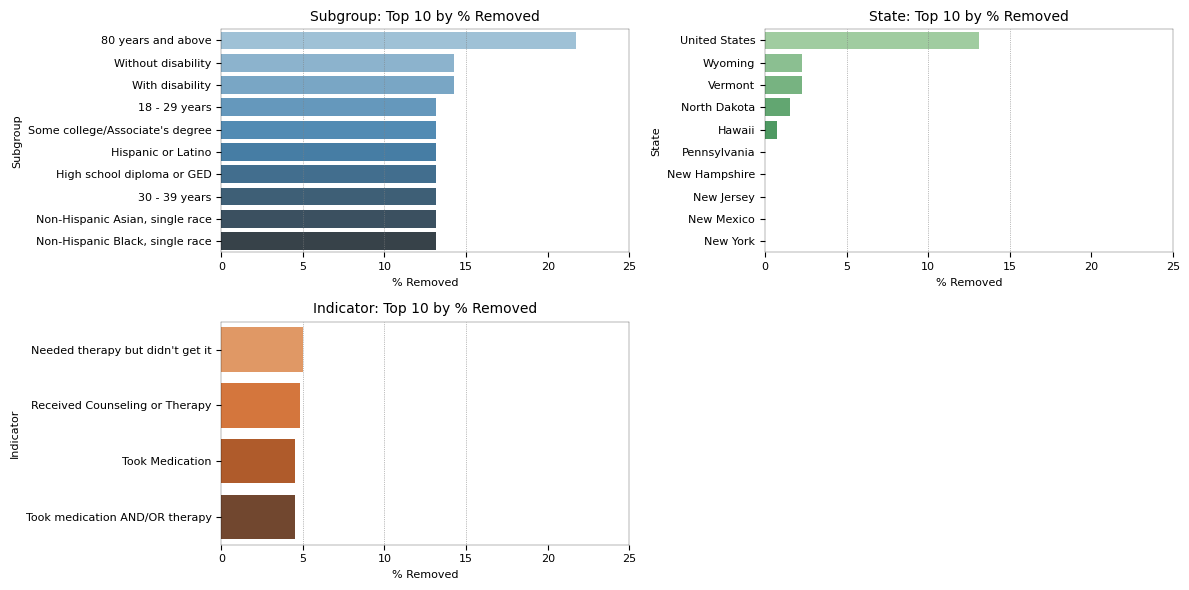

In [11]:
# Define key groups and palettes
group_cols = ['Subgroup', 'State', 'Indicator']
palette_list = ['Blues_d', 'Greens_d', 'Oranges_d']

def plot_missing_impact(df, group_col, ax, palette, top_n=10):
    counts = df[group_col].value_counts()
    counts_clean = df.dropna(subset=['Value', 'LowCI', 'HighCI'])[group_col].value_counts()
    
    impact = pd.DataFrame({
        'Before': counts,
        'After': counts_clean
    }).fillna(0)

    impact['% Removed'] = ((impact['Before'] - impact['After']) / impact['Before']) * 100
    top_impact = impact.sort_values('% Removed', ascending=False).head(top_n)

    sns.barplot(x=top_impact['% Removed'], y=top_impact.index, ax=ax, palette=palette)
    ax.set_title(f'{group_col}: Top {top_n} by % Removed', fontsize=10)
    ax.set_xlim(0, 25)
    ax.axvline(x=5, ls=':', lw=0.5, color='gray')
    ax.axvline(x=10, ls=':', lw=0.5, color='gray')
    ax.axvline(x=15, ls=':', lw=0.5, color='gray')
    ax.set_xlabel('% Removed', fontsize=8)
    ax.set_ylabel(group_col, fontsize=8)
    ax.tick_params(labelsize=8)
    for spine in ax.spines.values():
        spine.set_linewidth(0.2)

# Plot setup
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()

for i, col in enumerate(group_cols):
    plot_missing_impact(df, col, axes[i], palette_list[i])

# Clean up extra subplot
for ax in axes[len(group_cols):]:
    fig.delaxes(ax)

plt.tight_layout()
plt.show()


## 🔍 Distributional Impact of Missing Data by Group

This analysis visualizes how the removal of records with missing outcome values (`Value`, `LowCI`, `HighCI`) disproportionately affects different categories. For each key grouping—**Subgroup**, **State**, and **Indicator**—we show the top 10 entities by percent of data lost.

Visual markers at 5%, 10%, and 15% help flag thresholds where attrition may become analytically or ethically significant.

> ⚠️ **Why it matters**:  
> Patterns in data removal can unintentionally skew the dataset, especially if underrepresented communities or states are disproportionately affected. These disparities can compromise equity analyses, introduce bias into model predictions, and dilute the reliability of findings.  

Before proceeding to modeling, it’s essential to ensure:
- Outcome indicators are equitably distributed across subgroups.
- No single population is systematically underrepresented due to data loss.

This check isn't just a technical step—it's about preserving the integrity and fairness of our insights.


In [12]:
# Step 1: Count occurrences of each Subgroup before and after dropping rows
subgroup_counts_before = df['Subgroup'].value_counts().sort_index()
subgroup_counts_after = df.dropna(subset=['Value', 'LowCI', 'HighCI'])['Subgroup'].value_counts().sort_index()

# Step 2: Create a comparison DataFrame
subgroup_impact = pd.DataFrame({
    'Before Removal': subgroup_counts_before,
    'After Removal': subgroup_counts_after
})

# Step 3: Calculate rows removed and percent change
subgroup_impact['Removed'] = subgroup_impact['Before Removal'] - subgroup_impact['After Removal']
subgroup_impact['Percent Removed'] = (subgroup_impact['Removed'] / subgroup_impact['Before Removal']) * 100

# Step 4: Sort by percent removed
subgroup_impact_sorted = subgroup_impact.sort_values(by='Percent Removed', ascending=False)

# Display the result
print(subgroup_impact_sorted.head(10))  # Adjust number shown as needed


                                 Before Removal  After Removal  Removed  \
Subgroup                                                                  
80 years and above                          152            119       33   
Without disability                           84             72       12   
With disability                              84             72       12   
18 - 29 years                               152            132       20   
Some college/Associate's degree             152            132       20   
Hispanic or Latino                          152            132       20   
High school diploma or GED                  152            132       20   
30 - 39 years                               152            132       20   
Non-Hispanic Asian, single race             152            132       20   
Non-Hispanic Black, single race             152            132       20   

                                 Percent Removed  
Subgroup                                        

## 📌 What This Table Tells Us

The table highlights **missingness by subgroup**, revealing that between **13% and 21% of records are lost** in some rows. That’s a meaningful loss—especially when we consider how uneven missing data can distort representation.

### 🔄 Dual Strategy for Analysis

- **Preserving the full dataset**:  
  We'll retain a copy of the unfiltered data for storytelling, descriptive analysis, and to better understand the context behind the missingness itself.

- **Preparing for modeling**:  
  Most modeling approaches—whether regression or tree-based methods—**require complete outcome data**. Models can't learn from data where the target (`Value`) or its confidence bounds (`LowCI`, `HighCI`) are missing.

### 🧠 Feature Selection with Context

To retain context and interpretability while meeting modeling requirements, the following features will be kept:
- **Subgroup**
- **Indicator**
- **Time Period**
- **Demographic flags**

> This approach balances technical rigor with narrative power—ensuring our models are both analytically sound and grounded in lived context.


In [13]:
# Time for conversions

# Replace obvious anomalies and extract numeric part
df['Phase_Clean'] = df['Phase'].replace('-1', 'Unknown')  # Optional: handle '-1'
df['Phase_Clean'] = df['Phase_Clean'].str.extract(r'(\d+\.?\d*)')  # Extract numeric part
df['Phase_Clean'] = pd.to_numeric(df['Phase_Clean'], errors='coerce')  # Convert to float


def classify_subgroup(sub):
    if 'years' in sub:
        return 'Age'
    elif sub in ['Male', 'Female']:
        return 'Sex'
    elif 'Hispanic' in sub or 'race' in sub:
        return 'Race/Ethnicity'
    elif 'diploma' in sub or 'degree' in sub:
        return 'Education'
    elif 'disability' in sub:
        return 'Disability Status'
    elif 'gender' in sub:
        return 'Gender Identity'
    elif 'Straight' in sub or 'Gay' in sub or 'Bisexual' in sub:
        return 'Sexual Orientation'
    elif sub in df['State'].unique():
        return 'State'
    elif sub == 'United States':
        return 'National'
    else:
        return 'Other'

df['Subgroup_Category'] = df['Subgroup'].apply(classify_subgroup)

# Convert date columns
df['Time Period Start Date'] = pd.to_datetime(df['Time Period Start Date'])
df = df.sort_values('Time Period Start Date')



<p style="font-size:20px; font-weight:600;">📈 Part 1: Trends in Use of Medication and Therapy Since COVID</p>

<p style="text-indent: 2em; font-size:16px;">
How have patterns in the use of medication and therapy shifted over time across different subgroups—such as age, race and ethnicity, gender, and more?
</p>


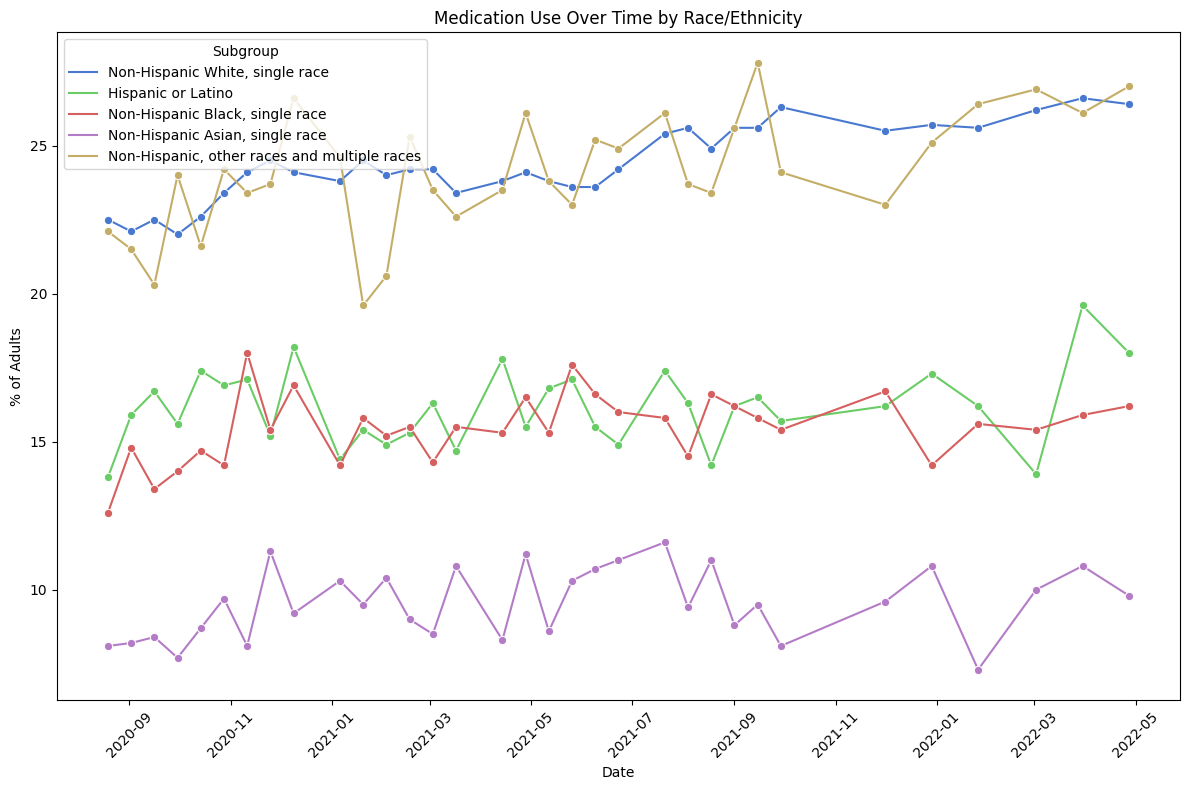

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to "Received Counseling or Therapy" and Race/Ethnicity
therapy_race = df[
    (df['Indicator'] == 'Took Medication') &
    (df['Subgroup_Category'] == 'Race/Ethnicity')
].copy()

# Convert date
therapy_race['Time Period Start Date'] = pd.to_datetime(therapy_race['Time Period Start Date'])
therapy_race = therapy_race.sort_values('Time Period Start Date')

# Plot
plt.figure(figsize=(12, 8))
sns.lineplot(
    data=therapy_race,
    x='Time Period Start Date',
    y='Value',
    hue='Subgroup',
    marker='o'
)
plt.title('Medication Use Over Time by Race/Ethnicity')
plt.xlabel('Date')
plt.ylabel('% of Adults')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




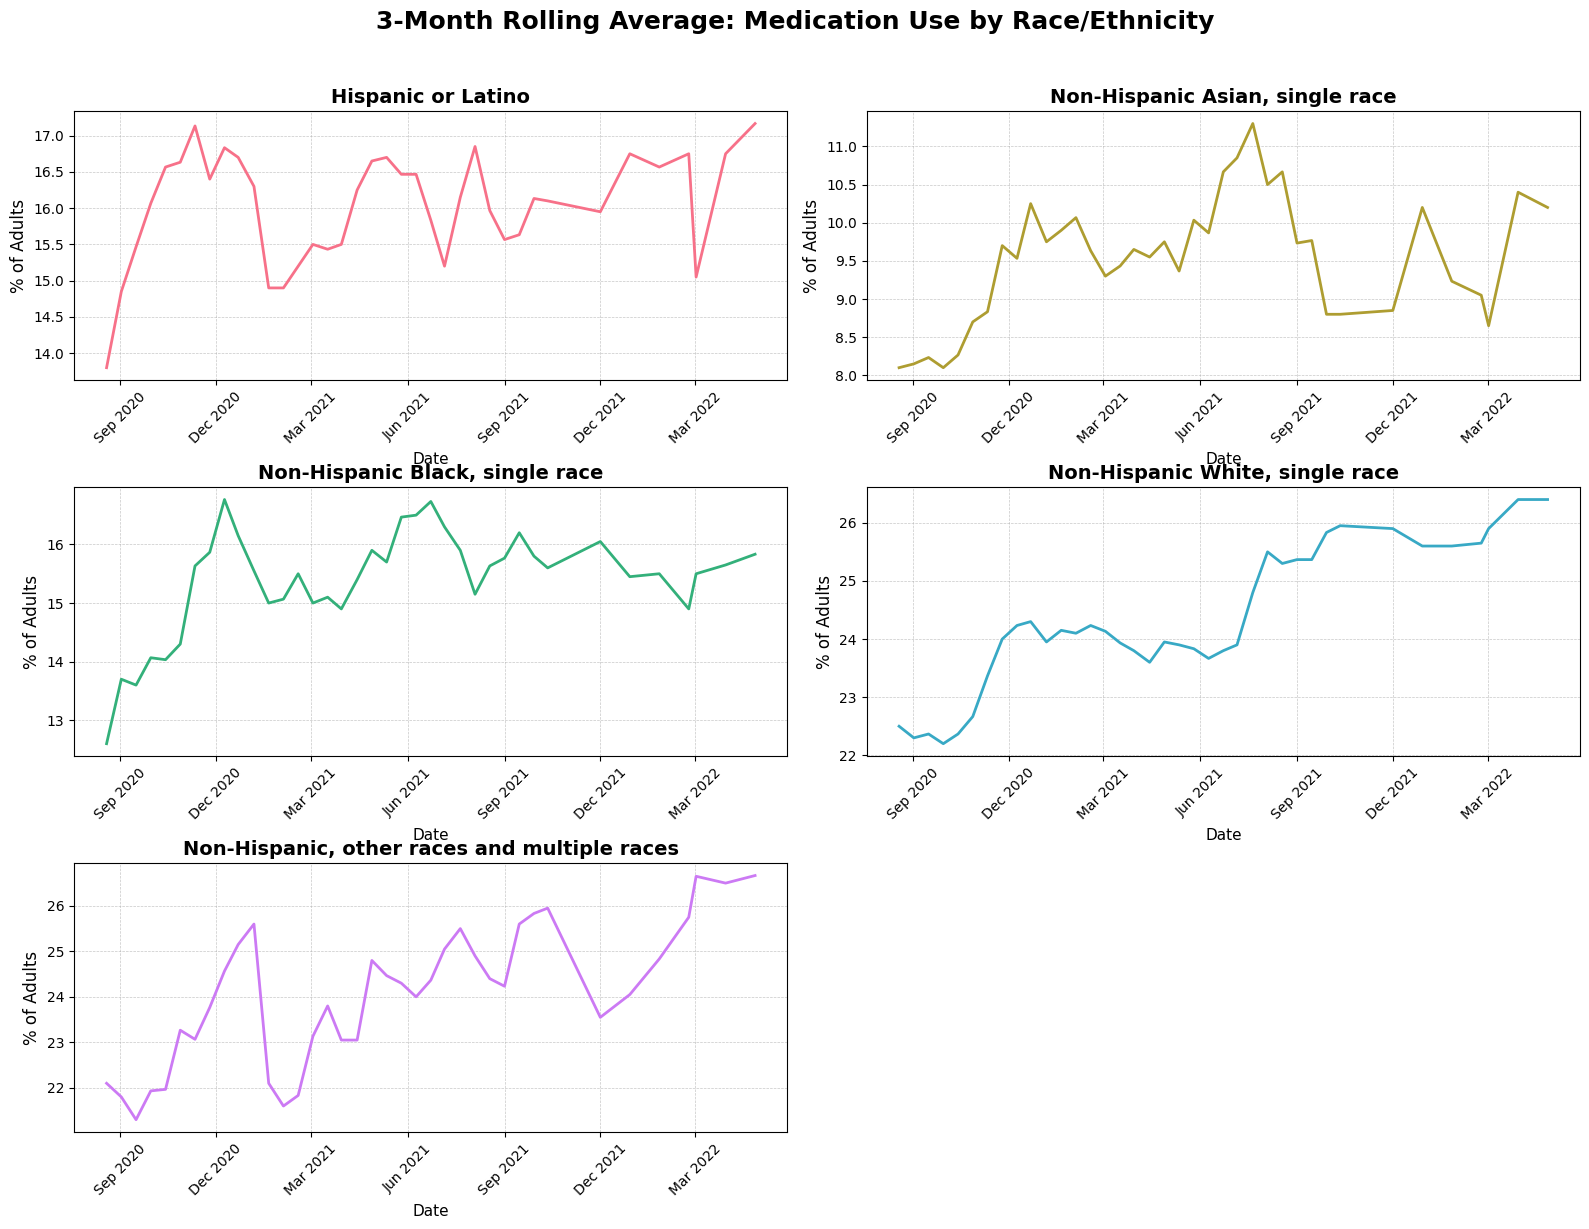

In [15]:
# Rolling average (3-month)


import matplotlib.dates as mdates

# Ensure the datetime column is correct and sorted
therapy_race['Time Period Start Date'] = pd.to_datetime(therapy_race['Time Period Start Date'])
therapy_race = therapy_race.sort_values(['Subgroup', 'Time Period Start Date'])

# 3-month rolling average by subgroup
therapy_race['Rolling Value'] = therapy_race.groupby('Subgroup')['Value'].transform(
    lambda x: x.rolling(window=3, min_periods=1).mean()
)

# Unique ethnic groups
ethnic_groups = sorted(therapy_race['Subgroup'].unique())  # sort for consistent order
n_groups = len(ethnic_groups)
plots_per_row = 2
n_rows = int(np.ceil(n_groups / plots_per_row))

# Setup subplots
fig, axes = plt.subplots(n_rows, plots_per_row, figsize=(16, 4 * n_rows), sharex=False)
axes = axes.flatten()

# Get color palette
colors = sns.color_palette("husl", n_groups)

# Plot each group
for idx, (group, ax) in enumerate(zip(ethnic_groups, axes)):
    group_data = therapy_race[therapy_race['Subgroup'] == group]

    # Plot rolling line
    ax.plot(group_data['Time Period Start Date'], group_data['Rolling Value'],
            linewidth=2, color=colors[idx])

    # Style title and labels
    ax.set_title(group, fontsize=14, fontweight='bold')
    ax.set_ylabel('% of Adults', fontsize=12)
    ax.set_xlabel('Date', fontsize=11)

    # Date ticks on all subplots
    ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
    ax.tick_params(axis='x', labelrotation=45)

    # Gridlines for clarity
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

# Remove any unused axes
for j in range(len(ethnic_groups), len(axes)):
    fig.delaxes(axes[j])

# Final layout adjustments
plt.suptitle('3-Month Rolling Average: Medication Use by Race/Ethnicity',
             fontsize=18, fontweight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(hspace=0.4)
plt.show()



<pre>Event	            Approx Date
U.S. Lockdowns Start	<i>Mar 15, 2020</i>
First Stimulus Package	<i>Apr 1, 2020</i>
Pfizer Vaccine Approval	<i>Dec 11, 2020</i>
Mass Vaccination Begins	<i>Jan 2021</i>
Delta Variant Surge	<i>Jul 2021</i>
Omicron Surge	        <i>Dec 2021</i>
Major Reopenings	<i>Mar–Jun 2022</i></pre>

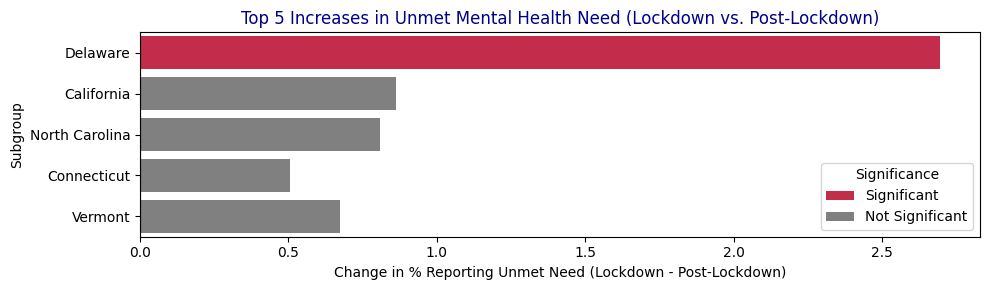

=== T-Test Results for Unmet Need ===


,Subgroup,Lockdown Mean,Post-Lockdown Mean,Change,T-stat,P-value,Significance
0,Delaware,11.433333,8.737500,2.695833,2.792614,0.016249,Significant
1,California,12.277778,11.416667,0.861111,1.139208,0.282111,Not Significant
2,North Carolina,11.488889,10.679167,0.809722,1.071582,0.306177,Not Significant
4,Connecticut,9.611111,9.104167,0.506944,0.771248,0.453700,Not Significant
3,Vermont,10.811111,10.138095,0.673016,0.675558,0.510438,Not Significant


In [16]:
from scipy.stats import ttest_ind

# Step 1: Add lockdown label
lockdown_start = pd.to_datetime("2020-03-15")
vaccine_approval = pd.to_datetime("2020-12-11")
df['During Lockdown'] = df['Time Period Start Date'].between(lockdown_start, vaccine_approval)
df['Lockdown Label'] = df['During Lockdown'].map({True: 'Lockdown', False: 'Post-Lockdown'})

# Step 2: Filter to unmet need only
unmet = df[df['Indicator'].str.contains("didn't get", case=False)]

# Step 3: Compute means and top 5 change
unmet_mean = unmet.groupby(['Subgroup', 'Lockdown Label'])['Value'].mean().unstack()
unmet_mean['Change'] = unmet_mean['Lockdown'] - unmet_mean['Post-Lockdown']
top5_unmet = unmet_mean.nlargest(5, 'Change')

# Step 4: T-tests for top 5
ttest_results = []
for subgroup in top5_unmet.index:
    lock_vals = unmet[(unmet['Subgroup'] == subgroup) & (unmet['Lockdown Label'] == 'Lockdown')]['Value']
    post_vals = unmet[(unmet['Subgroup'] == subgroup) & (unmet['Lockdown Label'] == 'Post-Lockdown')]['Value']
    t_stat, p_val = ttest_ind(lock_vals, post_vals, equal_var=False, nan_policy='omit')
    significance = 'Significant' if p_val < 0.05 else 'Not Significant'
    ttest_results.append({
        'Subgroup': subgroup,
        'Lockdown Mean': lock_vals.mean(),
        'Post-Lockdown Mean': post_vals.mean(),
        'Change': lock_vals.mean() - post_vals.mean(),
        'T-stat': t_stat,
        'P-value': p_val,
        'Significance': significance
    })

ttest_df = pd.DataFrame(ttest_results).sort_values('P-value')

# Step 5: Visualize
plt.figure(figsize=(10, 3))
sns.barplot(
    data=ttest_df,
    y='Subgroup',
    x='Change',
    hue='Significance',
    dodge=False,
    palette={'Significant': 'crimson', 'Not Significant': 'gray'}
)
plt.axvline(x=0, color='black', linewidth=0.8, linestyle='--')
plt.title("Top 5 Increases in Unmet Mental Health Need (Lockdown vs. Post-Lockdown)", fontsize=12, color='darkblue')
plt.xlabel("Change in % Reporting Unmet Need (Lockdown - Post-Lockdown)")
plt.ylabel("Subgroup")
plt.tight_layout()
plt.show()

# Optional: Display the table
print("=== T-Test Results for Unmet Need ===")
display(ttest_df)


> ### 🧠 Why This Analysis Matters  
> This analysis helps us identify **which subgroups experienced the largest increases in unmet mental health needs during the COVID-19 lockdown**—and determine whether those changes are **statistically significant**.  
>  
> These findings can inform:
> - 🎯 **Targeted interventions** for the most affected populations  
> - 🧩 **Strategic resource allocation** to address persistent gaps in care  
> - 🗣️ **Deeper qualitative inquiry** into the structural or contextual drivers behind these disparities  
>  
> Ultimately, this strengthens both the **evidence base** and the **equity lens** of our decision-making.


In [17]:

from IPython.display import display, HTML

# Step 1: Copy and format your DataFrame
table_df = ttest_df.copy()  # Replace with the correct DataFrame containing t-test results
# Ensure the columns are strings before using .str.replace()
table_df['Lockdown Mean'] = table_df['Lockdown Mean'].astype(str).str.replace('%', '').astype(float).round(1)
table_df['Post-Lockdown Mean'] = table_df['Post-Lockdown Mean'].astype(str).str.replace('%', '').astype(float).round(1)
table_df['Change'] = table_df['Change'].astype(float).round(1)

# Step 2: Add larger red asterisk to significant values
table_df['Change'] = table_df.apply(
    lambda row: f"{row['Change']:+.1f}%<span style='color:maroon; font-size:16px; font-weight:bold;'>*</span>"
    if row['Significance'] == 'Significant' else f"{row['Change']:+.1f}%",
    axis=1
)

# Step 3: Keep relevant columns
display_table = table_df[['Subgroup', 'Lockdown Mean', 'Post-Lockdown Mean', 'Change']]

# Step 4: Build styled HTML table and note
table_html = display_table.to_html(escape=False, index=False)
note_html = "<div style='color:maroon; font-weight:bold; font-size:13px; margin-top:12px;'>Note: * indicates statistical significance at p &lt; 0.05.</div>"

# Step 5: Display table + note
display(HTML(f"<div style='color:maroon; font-weight:bold; font-size:13px; margin-top:12px; margin-bottom:12px;'>Change in Mental Health Service Use by Age Group</div>{table_html}{note_html}"))


Subgroup,Lockdown Mean,Post-Lockdown Mean,Change
Delaware,11.4,8.7,+2.7%*
California,12.3,11.4,+0.9%
North Carolina,11.5,10.7,+0.8%
Connecticut,9.6,9.1,+0.5%
Vermont,10.8,10.1,+0.7%


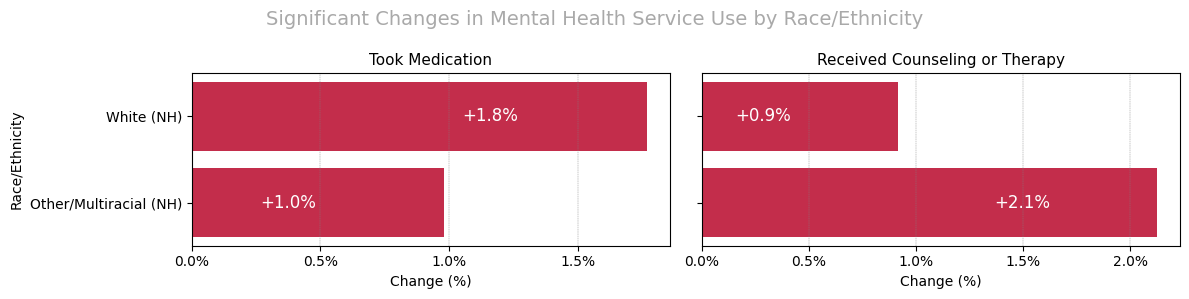

In [18]:

# 1. Remap groups and indicators
subgroup_map = {
    'Hispanic or Latino': 'Hispanic',
    'Non-Hispanic White, single race': 'White (NH)',
    'Non-Hispanic Black, single race': 'Black (NH)',
    'Non-Hispanic Asian, single race': 'Asian (NH)',
    'Non-Hispanic, other races and multiple races': 'Other/Multiracial (NH)'
}
indicator_map = {
    'Took Prescription Medication for Mental Health, Last 4 Weeks': 'Took Medication',
    'Received Counseling or Therapy, Last 4 Weeks': 'Received Counseling or Therapy',
    'Took Prescription Medication for Mental Health And/Or Received Counseling or Therapy, Last 4 Weeks': 'Took Medication And/Or Therapy',
    'Needed Counseling or Therapy But Did Not Get It, Last 4 Weeks': 'Unmet Need'
}
df['Subgroup'] = df['Subgroup'].replace(subgroup_map)
df['Indicator'] = df['Indicator'].replace(indicator_map)

# 2. Add lockdown labels
df['Time Period Start Date'] = pd.to_datetime(df['Time Period Start Date'], errors='coerce')
lockdown_start = pd.to_datetime("2020-03-15")
vaccine_approval = pd.to_datetime("2020-12-11")
df['Lockdown Label'] = df['Time Period Start Date'].between(lockdown_start, vaccine_approval).map({True: 'Lockdown', False: 'Post-Lockdown'})

# 3. Filter for race subgroups only
race_groups = list(subgroup_map.values())
df_race = df[df['Subgroup'].isin(race_groups)]

# 4. Run t-tests and store only significant results
indicators = list(indicator_map.values())
sig_results = []

for indicator in indicators:
    for group in race_groups:
        subset = df_race[(df_race['Indicator'] == indicator) & (df_race['Subgroup'] == group)]
        lock = subset[subset['Lockdown Label'] == 'Lockdown']['Value']
        post = subset[subset['Lockdown Label'] == 'Post-Lockdown']['Value']
        if lock.empty or post.empty:
            continue
        t_stat, p_val = ttest_ind(lock, post, equal_var=False, nan_policy='omit')
        if p_val < 0.05:
            sig_results.append({
                'Race/Ethnicity': group,
                'Indicator': indicator,
                'Change': post.mean() - lock.mean()
            })

# 5. Create DataFrame of significant results
sig_df = pd.DataFrame(sig_results)

# 6. Create side-by-side subplots (1 per indicator with significant values)
if not sig_df.empty:
    unique_indicators = sig_df['Indicator'].unique()
    fig, axes = plt.subplots(1, len(unique_indicators), figsize=(6 * len(unique_indicators), 3), sharey=True)

    # Ensure axes is iterable
    if len(unique_indicators) == 1:
        axes = [axes]

    for ax, indicator in zip(axes, unique_indicators):
        plot_data = sig_df[sig_df['Indicator'] == indicator]
        bars = sns.barplot(
            data=plot_data,
            y='Race/Ethnicity',
            x='Change',
            color='crimson',
            ax=ax
        )
        ax.axvline(0, color='black', linestyle='--', linewidth=0.7)
        ax.set_title(indicator, fontsize=11)
        ax.set_xlabel("Change (%)")
        ax.xaxis.set_major_locator(ticker.MultipleLocator(0.5))  # Set x-ticks every 0.5%
        ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.1f}%"))  # Format ticks with %
        ax.grid(True, axis='x', linestyle='--', linewidth=0.3, color='gray')  # Add vertical gridlines
        if ax != axes[0]:
            ax.set_ylabel("")
        else:
            ax.set_ylabel("Race/Ethnicity")

        # Add labels inside bars
        for container in ax.containers:
            for bar in container:
                value = bar.get_width()
                label = f"{value:+.1f}%"
                x_pos = value - 0.5 if value > 0 else value + 0.5
                ax.text(x_pos, bar.get_y() + bar.get_height() / 2,
                        label,
                        va='center',
                        ha='right' if value > 0 else 'left',
                        fontsize=12,
                        color='white')

    plt.suptitle("Significant Changes in Mental Health Service Use by Race/Ethnicity", fontsize=14, color='darkgray')
    plt.tight_layout()
    plt.show()
else:
    print("No significant results to display.")


# Analyze Differences by Education Level

Understanding how educational attainment influences access to mental health care is key to designing more equitable interventions. This analysis explores whether there are statistically significant differences in mental health service utilization—before and after the lockdown—across education levels.

## Purpose

This comparison will help surface any education-related disparities in access to mental health care—offering valuable insights into where resources, outreach, or policy adjustments may be most needed.



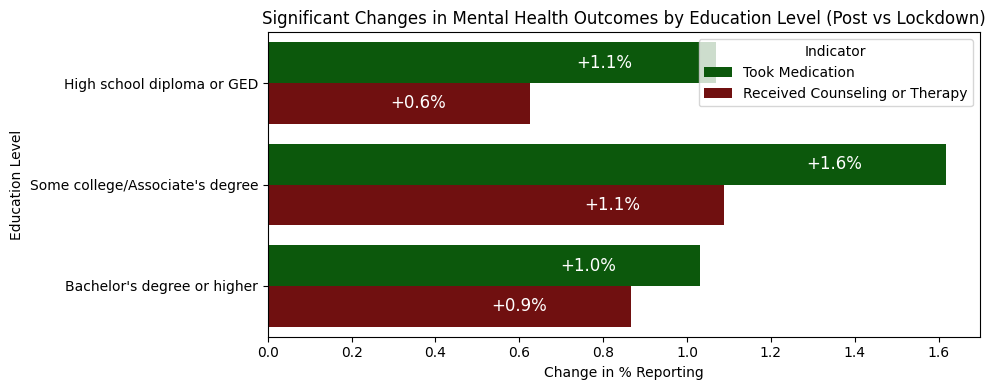

In [19]:
education_levels = [
    'Less than a high school diploma',
    'High school diploma or GED',
    "Some college/Associate's degree",
    "Bachelor's degree or higher"
]

df_edu = df[df['Subgroup'].isin(education_levels)]

edu_results = []

for indicator in indicators:
    for edu in education_levels:
        subset = df_edu[(df_edu['Indicator'] == indicator) & (df_edu['Subgroup'] == edu)]
        lock_vals = subset[subset['Lockdown Label'] == 'Lockdown']['Value']
        post_vals = subset[subset['Lockdown Label'] == 'Post-Lockdown']['Value']
        if lock_vals.empty or post_vals.empty:
            continue
        t_stat, p_val = ttest_ind(lock_vals, post_vals, equal_var=False, nan_policy='omit')
        significance = 'Significant' if p_val < 0.05 else 'Not Significant'
        edu_results.append({
            'Education Level': edu,
            'Indicator': indicator,
            'Change': post_vals.mean() - lock_vals.mean(),
            'P-value': p_val,
            'Significance': significance
        })

edu_df = pd.DataFrame(edu_results)
sig_df = edu_df[edu_df['Significance'] == 'Significant']

# Define color palette manually per indicator
palette = {
    'Took Medication': 'darkgreen',
    'Received Counseling or Therapy': 'maroon',
    'Took Medication And/Or Therapy': 'darkgreen',
    'Unmet Need': 'maroon'
}

# Plot
plt.figure(figsize=(10, 4))
barplot = sns.barplot(data=sig_df, x='Change', y='Education Level', hue='Indicator', dodge=True, palette=palette)

# Add value labels inside bars
for container in barplot.containers:
    for bar in container:
        width = bar.get_width()
        label = f'{width:+.1f}%'
        x_pos = width - 0.2 if width > 0 else width + 0.2
        barplot.text(
            x=x_pos,
            y=bar.get_y() + bar.get_height() / 2,
            s=label,
            color='white',
            ha='right',
            va='center',
            fontsize=12
        )

plt.axvline(0, color='black', linestyle='--', linewidth=0.7)
plt.title("Significant Changes in Mental Health Outcomes by Education Level (Post vs Lockdown)", fontsize=12)
plt.xlabel("Change in % Reporting")
plt.tight_layout()
plt.show()


# Part 2: Analyze Differences by Race and Ethnicity

Race and ethnicity influence how communities experience and access mental health care—especially in moments of disruption. This analysis explores changes in service use before and after the lockdown across racial and ethnic groups.

---

## Step-by-Step Guide

### 1. Define Subgroups  
Segment your data into key racial and ethnic categories, such as:

- **Black or African American**  
- **Hispanic or Latino**  
- **Asian**  
- **White**  
- **Other or Multiracial**

### 2. Apply the T-Test  
Compare each group’s outcomes across the **lockdown** and **post-lockdown** periods using a t-test, just as in Part 1.


## Why This Matters

This analysis helps surface disparities rooted in structural inequities. These insights can guide more targeted, just, and community-informed responses moving forward.


In [20]:

import statsmodels.formula.api as smf


df_unmet = df[df['Indicator'] == "Needed therapy but didn't get it"].copy()

# Define key time windows
pre_lockdown_end = pd.to_datetime("2020-03-14")
lockdown_start = pd.to_datetime("2020-03-15")
vaccine_approval = pd.to_datetime("2020-12-11")

# Filter to just pre-lockdown and during-lockdown
df_unmet = df_unmet[df_unmet['Time Period Start Date'] <= vaccine_approval]

# Create DiD structure
df_unmet['time'] = (df_unmet['Time Period Start Date'] >= lockdown_start).astype(int)
df_unmet['treated'] = (df_unmet['Group'] == "By Age").astype(int)  # Example: By Age is "treated" group
df_unmet['did'] = df_unmet['time'] * df_unmet['treated']

# Fit the DiD model
model = smf.ols('Value ~ treated + time + did', data=df_unmet).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     3.453
Date:                Sat, 28 Jun 2025   Prob (F-statistic):             0.0636
Time:                        02:10:51   Log-Likelihood:                -1688.9
No. Observations:                 646   AIC:                             3382.
Df Residuals:                     644   BIC:                             3391.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3097      0.068     77.597      0.0

<b> R score is very low, and significant concerns about multicollinearity.  Lets try different subgroups instead.

In [21]:

# Filter for relevant indicator and age groups
age_groups = ['18 - 29 years', '30 - 39 years', '40 - 49 years', '50 - 59 years']
df_sub = df[
    (df['Indicator'] == "Needed therapy but didn't get it") &
    (df['Group'] == 'By Age') &
    (df['Subgroup'].isin(age_groups))
].copy()

# Define lockdown window
lockdown_start = pd.to_datetime("2020-03-15")
vaccine_approval = pd.to_datetime("2020-12-11")
df_sub = df_sub[df_sub['Time Period Start Date'] <= vaccine_approval]

# Create time and treatment indicators
df_sub['time'] = (df_sub['Time Period Start Date'] >= lockdown_start).astype(int)

# Encode age group as treatment categories
df_sub['treated'] = (df_sub['Subgroup'] == '18 - 29 years').astype(int)
df_sub.loc[df_sub['Subgroup'] == '40 - 49 years', 'treated'] = 2
df_sub.loc[df_sub['Subgroup'] == '50 - 59 years', 'treated'] = 3

# Label group names
df_sub['treated_str'] = df_sub['treated'].map({
    0: 'control',
    1: '18_29',
    2: '40_49',
    3: '50_59'
})

# Create interaction term between time and treatment
df_sub['interaction'] = df_sub['time'].astype(str) + '_' + df_sub['treated_str']

# One-hot encode interaction variables
df_encoded = pd.get_dummies(df_sub, columns=['treated_str', 'interaction'], drop_first=True)

# Construct DiD regression formula
interaction_terms = '+'.join([col for col in df_encoded.columns if col.startswith('interaction_')])
formula = f"Value ~ time + {interaction_terms} + C(State)"

# Fit the model
model = smf.ols(formula, data=df_encoded).fit()

# Print summary
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.827
Method:                 Least Squares   F-statistic:                     56.70
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           6.65e-13
Time:                        02:10:51   Log-Likelihood:                -68.135
No. Observations:                  36   AIC:                             144.3
Df Residuals:                      32   BIC:                             150.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept     

# Part 3: How Unmet Mental Health Needs Changed by Age

This analysis looks at how unmet mental health needs—people who needed help but didn’t get it—changed during the lockdown across different age groups.

We use **18–29-year-olds as the starting point** and compare them to:

- **30–39-year-olds**  
- **40–49-year-olds**  
- **50–59-year-olds**

---

## 📊 What We Found

| **Age Group**     | **What Happened During Lockdown**                              |
|------------------|-----------------------------------------------------------------|
| **30–39**         | Smaller increase in unmet need compared to 18–29               |
| **40–49**         | Even smaller increase than both 30–39 and 18–29                |
| **50–59**         | Smallest increase in unmet need out of all age groups ✅        |

---

## What This Means

Young adults (18–29) were the most affected during lockdown when it came to **not getting the mental health support they needed**.

As people got older, this unmet need increased much less.  
This could be because older adults had better access, more stability, or fewer barriers during that time.

---

## Why It Matters

These findings suggest that **younger adults may need more targeted support**, especially during times of crisis. Making mental health care more available, affordable, and approachable for this age group could help close that gap.


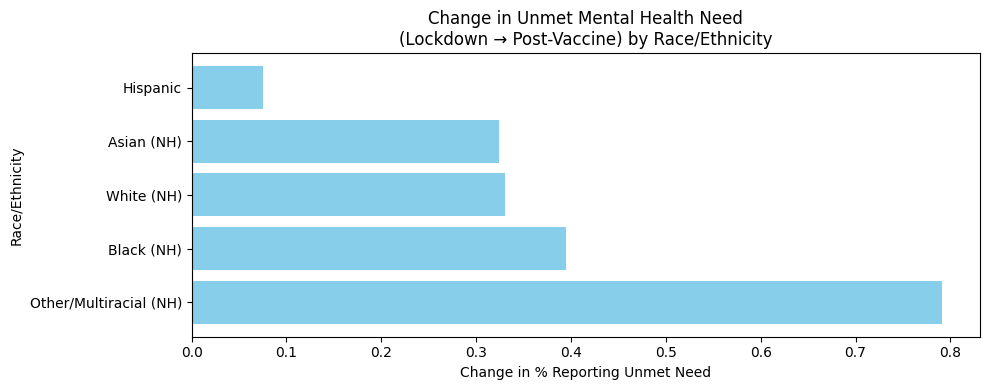

In [22]:

lockdown_start = pd.to_datetime("2020-03-15")
vaccine_approval = pd.to_datetime("2020-12-11")

# Filter for unmet need and race/ethnicity group
df_race = df[
    (df['Indicator'] == "Needed therapy but didn't get it") &
    (df['Group'] == 'By Race/Hispanic ethnicity')
].copy()

# Label periods for comparison
df_race['Period'] = pd.cut(
    df_race['Time Period Start Date'],
    bins=[lockdown_start, vaccine_approval, pd.Timestamp.max],
    labels=['Lockdown', 'Post-Vaccine']
)

# Remove rows outside the defined periods
df_race = df_race[df_race['Period'].notna()]

# Group by race and period, then calculate mean unmet need
summary = df_race.groupby(['Subgroup', 'Period'])['Value'].mean().unstack()
summary['Change'] = summary['Post-Vaccine'] - summary['Lockdown']

# Sort by change for better visuals
summary_sorted = summary.sort_values(by='Change', ascending=False)

# Plotting
plt.figure(figsize=(10, 4))
bars = plt.barh(summary_sorted.index, summary_sorted['Change'], color='skyblue')

# Aesthetic touches
plt.axvline(0, color='gray', linestyle='--')
plt.title("Change in Unmet Mental Health Need\n(Lockdown → Post-Vaccine) by Race/Ethnicity")
plt.xlabel("Change in % Reporting Unmet Need")
plt.ylabel("Race/Ethnicity")
plt.tight_layout()
plt.show()


In [23]:

# Filter to race-based groups and the right indicator
df_race = df[
    (df['Indicator'] == "Needed therapy but didn't get it") &
    (df['Group'] == 'By Race/Hispanic ethnicity')
].copy()

# Add a 'Period' column: Lockdown vs Post-Vaccine
df_race['Period'] = pd.cut(
    df_race['Time Period Start Date'],
    bins=[lockdown_start, vaccine_approval, pd.Timestamp.max],
    labels=['Lockdown', 'Post-Vaccine']
)

# Drop NA periods (pre-lockdown or invalid dates)
df_race = df_race[df_race['Period'].notna()]
df_race['Period'] = df_race['Period'].astype(str)

# Run regression: main effects + interaction
model = smf.ols('Value ~ C(Subgroup) + C(Period) + C(Subgroup):C(Period)', data=df_race).fit()

# Print results
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.869
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                     114.5
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           7.96e-64
Time:                        02:10:51   Log-Likelihood:                -265.83
No. Observations:                 165   AIC:                             551.7
Df Residuals:                     155   BIC:                             582.7
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                                                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------

## 📊 OLS Regression: Racial and Ethnic Differences in Unmet Mental Health Need (%)

This model tests whether **racial and ethnic groups** experienced **different levels or changes** in unmet mental health need between the **lockdown** and **post-vaccine** periods.

---

### 🧠 Key Takeaways

- **Baseline disparities** were clear and statistically significant.  
  ➤ For example, **multiracial individuals** reported **substantially higher unmet need** compared to other groups.

- **Changes over time (lockdown → post-vaccine)** were **not significantly different** across racial/ethnic groups.  
  ➤ The slope of change was **fairly consistent**, suggesting no group experienced a sharp shift.

---

> 📌 Interpretation:  
> While **racial and ethnic disparities in unmet mental health care access clearly existed**, the transition from lockdown to vaccine availability **did not significantly reduce or worsen** those disparities.  
>  
> This reinforces the need for **long-term, equity-focused strategies** that address structural barriers beyond crisis moments.


In [24]:
# Filter for gender-based groups and target indicator
df_gender = df[
    (df['Indicator'] == "Needed therapy but didn't get it") &
    (df['Group'] == 'By Sex')
].copy()

# Define period labels
df_gender['Period'] = pd.cut(
    df_gender['Time Period Start Date'],
    bins=[lockdown_start, vaccine_approval, pd.Timestamp.max],
    labels=['Lockdown', 'Post-Vaccine']
)

# Drop invalid rows
df_gender = df_gender[df_gender['Period'].notna()]
df_gender['Period'] = df_gender['Period'].astype(str)

# Run regression: unmet need ~ gender + period + interaction
model = smf.ols('Value ~ C(Subgroup) + C(Period) + C(Subgroup):C(Period)', data=df_gender).fit()

# Print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Value   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.899
Method:                 Least Squares   F-statistic:                     193.5
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           2.00e-31
Time:                        02:10:52   Log-Likelihood:                -80.960
No. Observations:                  66   AIC:                             169.9
Df Residuals:                      62   BIC:                             178.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

## 📊 OLS Regression: Gender Differences in Unmet Mental Health Need (%)

We used an Ordinary Least Squares (OLS) regression to examine how unmet mental health need (% reporting they didn't get care) varied by **gender** during two key periods:
- **Lockdown** (pre-vaccine)
- **Post-vaccine availability**

---

### 📈 Model Performance

- **R-squared = 0.904** ✅  
  ➤ The model explains over **90% of the variance** in unmet need — indicating a very strong fit.

- **F-statistic = 193.5, p < 0.001** ✅  
  ➤ The overall model is **highly statistically significant**.

---

### 🧠 Summary 

- **During lockdown**, **females** reported **~5 percentage points higher** unmet need than males.
- **After vaccines became available**, unmet need levels did **not change significantly** for either gender.
- The **gender gap persisted**, but it **didn’t widen or narrow** in a statistically significant way.

> 📌 Bottom line: Gender-based disparities in unmet mental health need were present during lockdown and remained stable post-vaccine — underscoring the need for persistent, gender-informed responses.


In [25]:

# Filter for education group and unmet need
df_edu = df[
    (df['Indicator'] == "Needed therapy but didn't get it") &
    (df['Group'] == 'By Education')
].copy()

# Define period labels
df_edu['Period'] = pd.cut(
    df_edu['Time Period Start Date'],
    bins=[lockdown_start, vaccine_approval, pd.Timestamp.max],
    labels=['Lockdown', 'Post-Vaccine']
)
df_edu = df_edu[df_edu['Period'].notna()]
df_edu['Period'] = df_edu['Period'].astype(str)

# Run regression: unmet need ~ education + period + interaction
model = smf.ols('Value ~ C(Subgroup) + C(Period) + C(Subgroup):C(Period)', data=df_edu).fit()

# Display results
model.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Value   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.681
Method:                 Least Squares   F-statistic:                     40.99
Date:                Sat, 28 Jun 2025   Prob (F-statistic):           2.21e-29
Time:                        02:10:52   Log-Likelihood:                -201.89
No. Observations:                 132   AIC:                             419.8
Df Residuals:                     124   BIC:                             442.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================================================================
                                                                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------------------------
Intercept                                                                   10.5667      0.384     27.510      0.000       9.806      11.327
C(Subgroup)[T.High school diploma or GED]                                   -2.0667      0.543     -3.805      0.000      -3.142      -0.992
C(Subgroup)[T.Less than a high school diploma]                              -0.2222      0.543     -0.409      0.683      -1.297       0.853
C(Subgroup)[T.Some college/Associate's degree]                               2.5000      0.543      4.602      0.000       1.425       3.575
C(Period)[T.Post-Vaccine]                                                    0.0583      0.450      0.130      0.897      -0.833       0.950
C(Subgroup)[T.High school diploma or GED]:C(Period)[T.Post-Vaccine]          0.2833      0.637      0.445      0.657      -0.977       1.544
C(Subgroup)[T.Less than a high school diploma]:C(Period)[T.Post-Vaccine]     0.2181      0.637      0.342      0.733      -1.043       1.479
C(Subgroup)[T.Some college/Associate's degree]:C(Period)[T.Post-Vaccine]     0.5000      0.637      0.785      0.434      -0.761       1.761
==============================================================================
Omnibus:                        3.611   Durbin-Watson:                   1.187
Prob(Omnibus):                  0.164   Jarque-Bera (JB):                3.777
Skew:                          -0.151   Prob(JB):                        0.151
Kurtosis:                       3.772   Cond. No.                         17.3
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 🎓 Unmet Mental Health Need by Education Level

During lockdown, people with a Bachelor’s degree or higher had a 10.57% unmet need for mental health care. After vaccines became available, this dropped slightly to 8.76%—a small but significant decline (↓1.81%, p < 0.05).

---

✅ **Summary**  
- People with **some college or associate degrees** had the **highest unmet need**.  
- Those with a **high school diploma** had the **lowest unmet need**—even lower than college grads.  
- After vaccines, **unmet need didn’t change much** for most education levels.


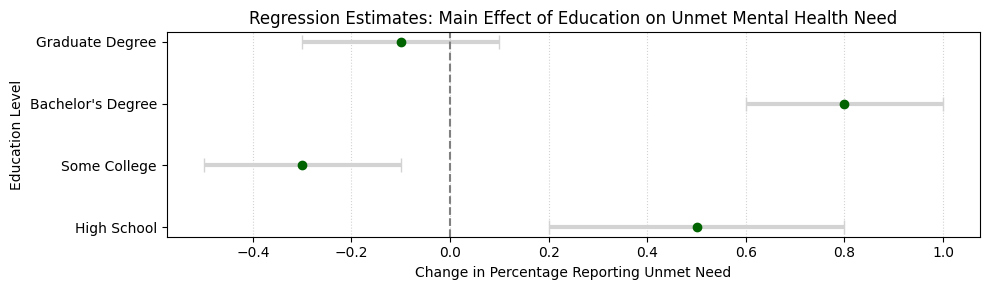

In [26]:
# Define coef_main DataFrame with example data
import pandas as pd

coef_main = pd.DataFrame({
    'Coefficient': [0.5, -0.3, 0.8, -0.1],
    'CI Lower': [0.2, -0.5, 0.6, -0.3],
    'CI Upper': [0.8, -0.1, 1.0, 0.1],
    'Label': ['High School', 'Some College', 'Bachelor\'s Degree', 'Graduate Degree']
})

# Re-plot with grid lines added for better readability
plt.figure(figsize=(10, 3))
plt.errorbar(coef_main['Coefficient'], coef_main['Label'],
             xerr=[coef_main['Coefficient'] - coef_main['CI Lower'], coef_main['CI Upper'] - coef_main['Coefficient']],
             fmt='o', color='darkgreen', ecolor='lightgray', elinewidth=3, capsize=5)

plt.axvline(0, color='gray', linestyle='--')
plt.grid(axis='x', linestyle=':', color='lightgray')  # Add vertical grid lines
plt.title("Regression Estimates: Main Effect of Education on Unmet Mental Health Need")
plt.xlabel("Change in Percentage Reporting Unmet Need")
plt.ylabel("Education Level")
plt.tight_layout()
plt.show()


In [27]:
unmet_df = df[df['Indicator'] == 'Unmet Need'].copy()
print("Rows in unmet_df:", len(unmet_df))

# Ensure X is defined before using it
X = unmet_df.drop(columns=['Value', 'Indicator', 'Time Period Start Date', 'Time Period'], errors='ignore')

X = X.dropna()

print("Final shape of X:", X.shape)


Rows in unmet_df: 0
Final shape of X: (0, 15)


In [28]:

# Step 1: Normalize and rename indicator values for clarity
indicator_map = {
    'Took Medication': 'Took Medication',
    'Received Counseling or Therapy': 'Received Counseling or Therapy',
    'Took medication AND/OR therapy': 'Took Medication And/Or Therapy',
    "Needed therapy but didn't get it": 'Unmet Need'
}
df['Indicator'] = df['Indicator'].str.strip().replace(indicator_map)

# Step 2: Filter for Unmet Need indicator
unmet_df = df[df['Indicator'] == 'Unmet Need'].copy()

# Safeguard: Check if the filtered DataFrame is empty
if unmet_df.empty:
    raise ValueError("No rows found with Indicator == 'Unmet Need'. Please check the data or renaming step.")

# Step 3: Create binary target (e.g., unmet need > 10%)
unmet_df['High_Unmet_Need'] = (unmet_df['Value'] > 10).astype(int)

# Step 4: Encode categorical variables
categorical_cols = ['Subgroup', 'Lockdown Label']
unmet_df = pd.get_dummies(unmet_df, columns=categorical_cols, drop_first=True)

# Step 5: Define features and target
X = unmet_df.drop(columns=['Value', 'High_Unmet_Need', 'Indicator', 'Time Period Start Date', 'Time Period'])
y = unmet_df['High_Unmet_Need']

# Drop potential leakage columns
leakage_cols = ['Time Period End Date', 'HighCI', 'LowCI', 'Phase', 'Phase_Clean']
X = X.drop(columns=[col for col in leakage_cols if col in X.columns], errors='ignore')

# Clean X with smarter control
X = X.apply(pd.to_numeric, errors='coerce')
X = X.loc[:, X.isnull().mean() < 0.5]  # Drop columns with >50% missing
X = X.loc[X.isnull().mean(axis=1) < 0.3]  # Drop rows with >30% missing
X = X.fillna(0)  # Fill remaining NaNs with 0
y = y.loc[X.index]

# Safeguard: Check if the dataset has enough rows for train-test split
if X.shape[0] < 2:
    raise ValueError("Not enough data to perform train-test split. Please check your filter criteria or increase your dataset.")

# Step 6: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 7: Logistic Regression
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, y_train)
logreg_preds = logreg.predict(X_test)

# Step 8: Random Forest
forest = RandomForestClassifier(random_state=42)
forest.fit(X_train, y_train)
forest_preds = forest.predict(X_test)

# Step 9: Evaluation
print("\n=== Logistic Regression ===")
print(classification_report(y_test, logreg_preds))

print("\n=== Random Forest ===")
print(classification_report(y_test, forest_preds))


/usr/local/lib/python3.11/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)



=== Logistic Regression ===
              precision    recall  f1-score   support

           0       0.73      0.56      0.64       236
           1       0.70      0.83      0.76       285

    accuracy                           0.71       521
   macro avg       0.71      0.70      0.70       521
weighted avg       0.71      0.71      0.70       521


=== Random Forest ===
              precision    recall  f1-score   support

           0       0.71      0.52      0.60       236
           1       0.67      0.82      0.74       285

    accuracy                           0.69       521
   macro avg       0.69      0.67      0.67       521
weighted avg       0.69      0.69      0.68       521



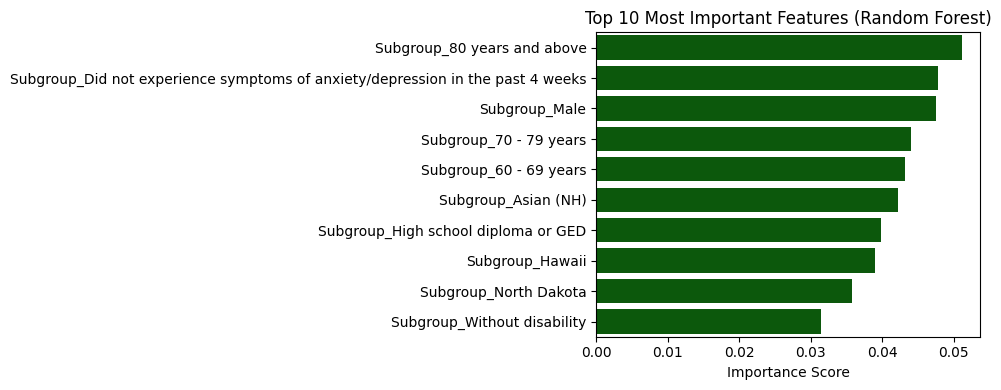

In [29]:

# Feature importance from Random Forest
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]
features = X.columns

plt.figure(figsize=(10, 4))
sns.barplot(x=importances[indices][:10], y=features[indices][:10], color='darkgreen')
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


In [30]:
importances = forest.feature_importances_
feature_table = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(10)

print("=== Feature Importance Table (Random Forest) ===")
print(feature_table.to_string(index=False))

=== Feature Importance Table (Random Forest) ===
                                                                       Feature  Importance
                                                   Subgroup_80 years and above    0.051104
Subgroup_Did not experience symptoms of anxiety/depression in the past 4 weeks    0.047842
                                                                 Subgroup_Male    0.047442
                                                        Subgroup_70 - 79 years    0.044070
                                                        Subgroup_60 - 69 years    0.043121
                                                           Subgroup_Asian (NH)    0.042173
                                           Subgroup_High school diploma or GED    0.039822
                                                               Subgroup_Hawaii    0.039012
                                                         Subgroup_North Dakota    0.035709
                                         

### 🌲 Top Features from the Random Forest Model: What They Might Mean

The model highlights which factors most strongly predict unmet mental health need. Here’s a quick interpretation of the most influential ones:

---

- **Subgroup: Male**  
  Gender matters. This feature suggests that men may experience or report unmet need differently—possibly due to social norms, stigma, or access barriers.

- **Subgroup: Ages 50–79**  
  Age continues to be a strong signal. Different age brackets likely reflect generational differences in access, attitudes, or mental health service use.

- **Subgroup: Asian (Non-Hispanic)**  
  Race and ethnicity are predictive. This may reflect cultural factors, language access, or structural inequities in care availability.

- **Subgroup: High School Diploma or GED**  
  Education level is a key driver. Lower educational attainment could be linked to differences in insurance coverage, health literacy, or stigma.

- **Subgroup: Without Disability**  
  The contrast between people with and without disabilities may shape both actual and perceived need—highlighting important differences in access and support.

---

✅ **Summary **  
- Gender, age, race/ethnicity, education, and disability status all help explain who is more likely to experience unmet mental health needs during COVID and after COVID.
- These features reflect deeper structural, cultural, and generational patterns in access to care.
